# Run Layer Fidelity (EPLG100) experiment using qiskit-experiments

`pip install "qiskit-experiments>=0.7" qiskit-ibm-provider` is required before running this notebook.

In [1]:
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity

In [2]:
import math
import numpy as np
import rustworkx as rx
import matplotlib.pyplot as plt

In [3]:
from qiskit_ibm_provider import IBMProvider

In [4]:
provider = IBMProvider()

In [5]:
#specify backend and two-qubit gate to be layered 
backend = provider.get_backend('ibm_kyoto')
twoq_gate = "ecr"
print(f"Device {backend.name} Loaded with {backend.num_qubits} qubits")
print(f"Two Qubit Gate: {twoq_gate}")

Device ibm_kyoto Loaded with 127 qubits
Two Qubit Gate: ecr


### Find the best qubit chain based on reported 2q-gate errors
If you want to benchmark EPLG (error per layered gate) on 100 qubits, set `num_qubits_in_chain==100`

In [6]:
num_qubits_in_chain = 100
coupling_map = backend.target.build_coupling_map(twoq_gate)
G = coupling_map.graph

In [7]:
def to_edges(path):
    edges = []
    prev_node = None
    for node in path:
        if prev_node is not None:
            if G.has_edge(prev_node, node):
                edges.append((prev_node, node))
            else:
                edges.append((node, prev_node))
        prev_node = node
    return edges
    
def path_cost(path, correct_by_duration=True):
    """Compute cost of a path. The path is given in node indices form, e.g. [0, 1, 2].
    Use `to_edges` function to obtain edge list, e.g. [(0, 1), (1, 2)]."""
    max_duration = max(backend.target[twoq_gate][qs].duration for qs in to_edges(path))
    
    def gate_error(qpair):
        duration = backend.target[twoq_gate][qpair].duration
        factor = max_duration / duration if correct_by_duration else 1.0
        return factor * backend.target[twoq_gate][qpair].error
    
    gate_cost = -np.prod([1-0.8*gate_error(qs) for qs in to_edges(path)])
    readout_cost = 0
    return gate_cost + readout_cost

def flatten(paths):
    return [val for ps in paths.values() for vals in ps.values() for val in vals]

paths = rx.all_pairs_all_simple_paths(G.to_undirected(multigraph=False), min_depth=num_qubits_in_chain, cutoff=num_qubits_in_chain)
if not flatten(paths):
    raise Exception(f"No qubit chain with length={num_qubits_in_chain} exists in {backend.name}. Try smaller num_qubits_in_chain.")

print(f"Selecting the best from {len(flatten(paths))} candidate paths (will take a few minutes)")
best_qubit_chain =  min(flatten(paths), key=path_cost)
assert(len(best_qubit_chain) == num_qubits_in_chain)
print(f"Predicted LF from reported 2q-gate EPGs: {-path_cost(best_qubit_chain)}")

Selecting the best from 313980 candidate paths (will take a few minutes)
Predicted LF from reported 2q-gate EPGs: 0.36495139725549536


In [8]:
np.array(best_qubit_chain)

array([112, 108, 107, 106, 105, 104, 111, 122, 121, 120, 119, 118, 110,
       100, 101, 102,  92,  83,  82,  81,  80,  79,  91,  98,  97,  96,
        95,  94,  90,  75,  76,  77,  71,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  73,  85,  86,  87,  88,  89,  74,  70,  69,  68,
        55,  49,  50,  51,  36,  32,  31,  30,  17,  12,  11,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1,   0,  14,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  35,  47,  46,  45,  44,
        43,  42,  41,  40,  39,  38,  37,  52,  56], dtype=uint64)

In [9]:
# decompose the chain into two disjoint layers
all_pairs = to_edges(best_qubit_chain)
two_disjoint_layers = [all_pairs[0::2], all_pairs[1::2]]
two_disjoint_layers

[[(112, 108),
  (106, 107),
  (105, 104),
  (122, 111),
  (121, 120),
  (119, 118),
  (110, 100),
  (101, 102),
  (83, 92),
  (82, 81),
  (80, 79),
  (98, 91),
  (96, 97),
  (94, 95),
  (75, 90),
  (76, 77),
  (71, 58),
  (59, 60),
  (62, 61),
  (63, 64),
  (65, 66),
  (73, 85),
  (87, 86),
  (89, 88),
  (74, 70),
  (68, 69),
  (49, 55),
  (50, 51),
  (32, 36),
  (30, 31),
  (17, 12),
  (11, 10),
  (8, 9),
  (7, 6),
  (4, 5),
  (3, 2),
  (1, 0),
  (18, 14),
  (19, 20),
  (22, 21),
  (23, 24),
  (25, 26),
  (27, 28),
  (47, 35),
  (46, 45),
  (44, 43),
  (42, 41),
  (39, 40),
  (37, 38),
  (56, 52)],
 [(107, 108),
  (105, 106),
  (104, 111),
  (122, 121),
  (120, 119),
  (118, 110),
  (101, 100),
  (102, 92),
  (82, 83),
  (81, 80),
  (79, 91),
  (97, 98),
  (96, 95),
  (94, 90),
  (76, 75),
  (77, 71),
  (59, 58),
  (61, 60),
  (62, 63),
  (64, 65),
  (73, 66),
  (86, 85),
  (88, 87),
  (89, 74),
  (70, 69),
  (55, 68),
  (50, 49),
  (51, 36),
  (31, 32),
  (17, 30),
  (11, 12),
  (9, 

## Define a LayerFidelity experiment

- `physical_qubits`: Physical qubits to use in this benchmarking
- `two_qubit_layers`: List of list of qubit pairs (a list of qubit pairs corresponds with a two-qubit gate layer), qubit direction matters
- `lengths`: List of layer lengths (the number of depth points)
- `backend`: Backend to be benchmarked
- `num_samples`: How many random circuits should be sampled for each layer length
- `seed`: Seed for the random number generator

[Optional]
- `two_qubit_gate`: Two-qubit gate name to use in layers (If not specified, one of 2q-gates supported in the backend is automatically set.)
- `one_qubit_basis_gates`: One-qubit gate names to use for random 1q-Clifford layers (If not specified, all 1q-gates supported in the backend are automatically set.)

In [10]:
%%time
lfexp = LayerFidelity(
    physical_qubits=best_qubit_chain,
    two_qubit_layers=two_disjoint_layers,
    lengths=[2, 4, 8, 16, 30, 50, 70, 100, 150, 200, 300, 500],
    backend=backend,
    num_samples=12,
    seed=42,
    # two_qubit_gate="ecr",
    # one_qubit_basis_gates=["rz", "sx", "x"],
)

CPU times: user 20.2 ms, sys: 504 µs, total: 20.7 ms
Wall time: 20.5 ms


In [11]:
lfexp.experiment_options

Options(max_circuits=None, lengths=[2, 4, 8, 16, 30, 50, 70, 100, 150, 200, 300, 500], num_samples=12, seed=42, two_qubit_layers=[[(112, 108), (106, 107), (105, 104), (122, 111), (121, 120), (119, 118), (110, 100), (101, 102), (83, 92), (82, 81), (80, 79), (98, 91), (96, 97), (94, 95), (75, 90), (76, 77), (71, 58), (59, 60), (62, 61), (63, 64), (65, 66), (73, 85), (87, 86), (89, 88), (74, 70), (68, 69), (49, 55), (50, 51), (32, 36), (30, 31), (17, 12), (11, 10), (8, 9), (7, 6), (4, 5), (3, 2), (1, 0), (18, 14), (19, 20), (22, 21), (23, 24), (25, 26), (27, 28), (47, 35), (46, 45), (44, 43), (42, 41), (39, 40), (37, 38), (56, 52)], [(107, 108), (105, 106), (104, 111), (122, 121), (120, 119), (118, 110), (101, 100), (102, 92), (82, 83), (81, 80), (79, 91), (97, 98), (96, 95), (94, 90), (76, 75), (77, 71), (59, 58), (61, 60), (62, 63), (64, 65), (73, 66), (86, 85), (88, 87), (89, 74), (70, 69), (55, 68), (50, 49), (51, 36), (31, 32), (17, 30), (11, 12), (9, 10), (8, 7), (6, 5), (4, 3), (1,

In [12]:
print(f"Two Qubit Gate: {lfexp.experiment_options.two_qubit_gate}")
print(f"One Qubit Gate Set: {lfexp.experiment_options.one_qubit_basis_gates}")

Two Qubit Gate: ecr
One Qubit Gate Set: ('sx', 'id', 'x', 'rz')


### Quick look at a RB circuit
`circuits_geenrator` is useful for that.

CPU times: user 3.31 s, sys: 24.6 ms, total: 3.33 s
Wall time: 3.34 s


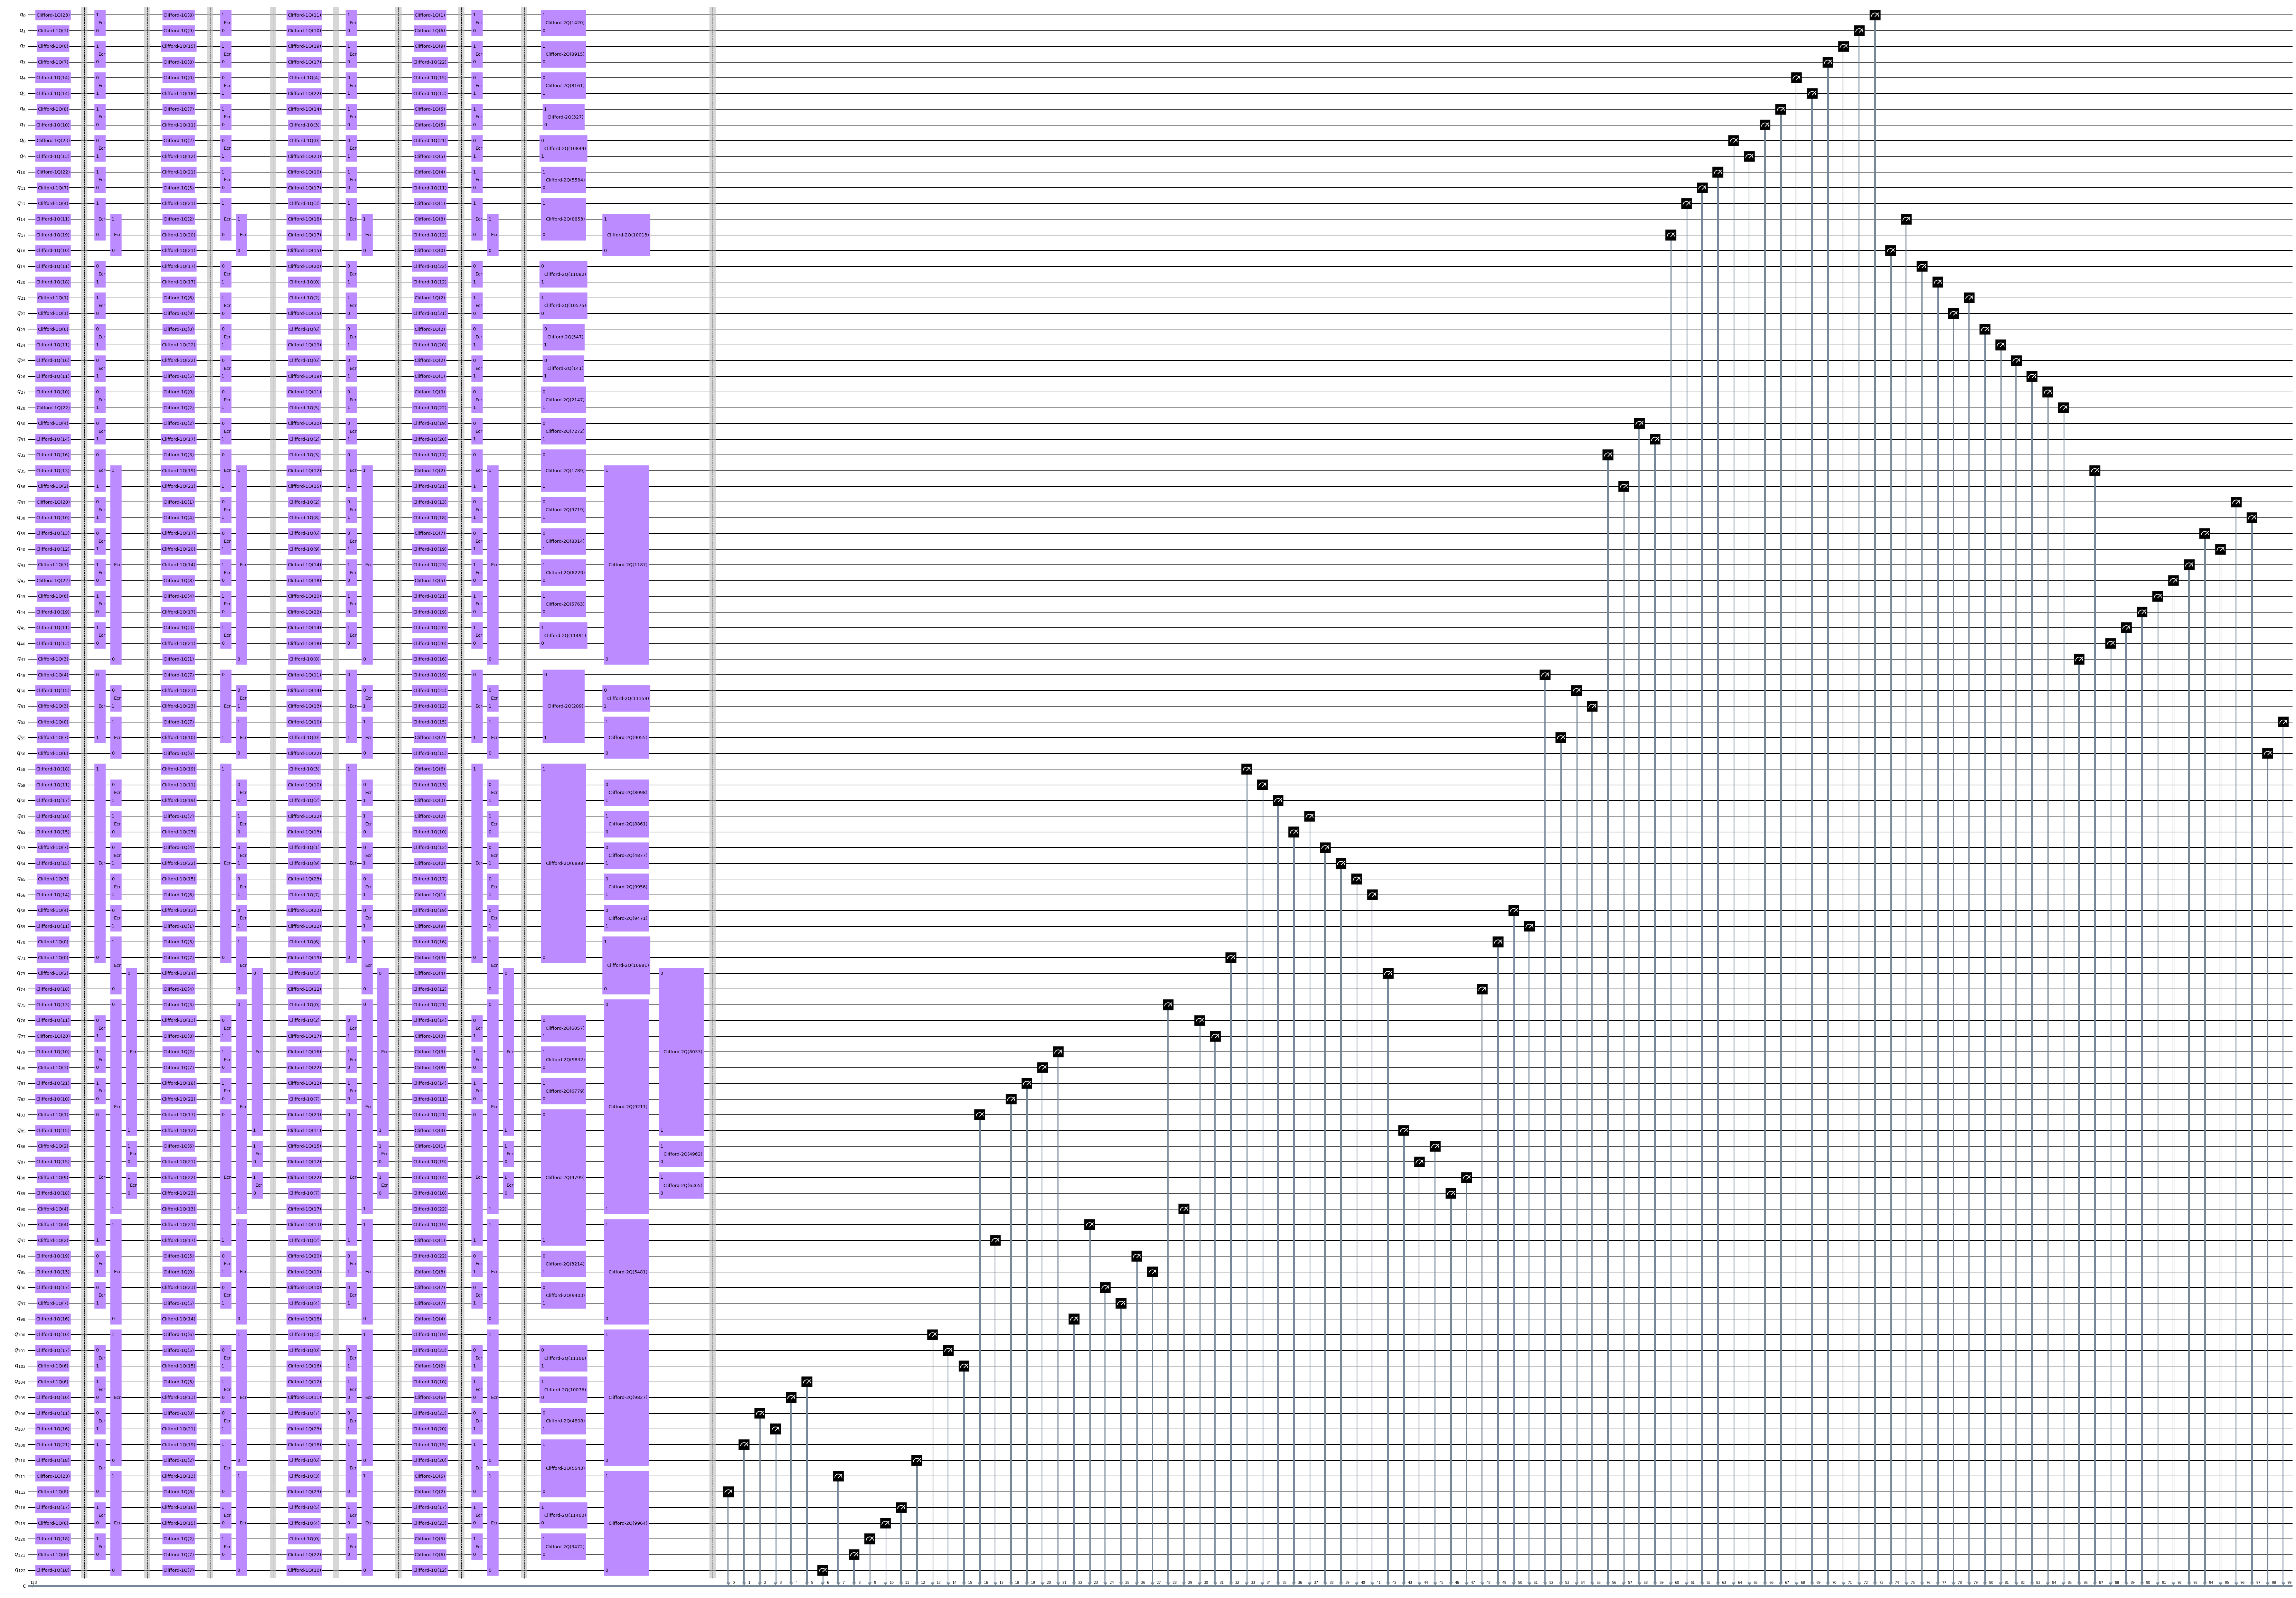

In [13]:
%%time
# look at one of the first three 2Q direct RB circuits quickly
circ_iter = lfexp.circuits_generator()
first_three_circuits = list(next(circ_iter) for _ in range(3))
first_three_circuits[1].draw(output="mpl", style="clifford", idle_wires=False, fold=-1)

### Generating all RB circuits takes a bit more time

In [14]:
%%time
# generate all circuits to run
circuits = lfexp.circuits()
print(f"{len(circuits)} circuits are generated.")

288 circuits are generated.
CPU times: user 43 s, sys: 68.5 ms, total: 43.1 s
Wall time: 43.2 s


## Run the Layer Fidelity experiment

Run = Generate circuits and submit the job to the backend.

Set `exp_data.auto_save = True` to store the experiment data using qiskit-ibm-experiment service.

In [15]:
%%time
#number of shots per job
nshots = 400

# Run the LF experiment (generate circuits and submit the job)
exp_data = lfexp.run(shots=nshots)
# exp_data.auto_save = True
print(f"Run experiment: ID={exp_data.experiment_id} with jobs {exp_data.job_ids}]")

Run experiment: ID=368f151b-63e9-49db-a36e-66a365948644 with jobs ['cqxrpb9p3cg0008cjds0']]
CPU times: user 1min 59s, sys: 371 ms, total: 2min
Wall time: 2min 17s


## Wait for the result
Retrieve the result after the job is completed and run analysis (fit RB curves and estimate process fidelity for each 1Q/2Q direct RB)

In [16]:
%%time
exp_data.block_for_results()

CPU times: user 5h 27min 43s, sys: 3min 18s, total: 5h 31min 1s
Wall time: 6h 15min 9s


ExperimentData(LayerFidelity, 368f151b-63e9-49db-a36e-66a365948644, job_ids=['cqxrpb9p3cg0008cjds0'], metadata=<4 items>, figure_names=['DirectRB_Q112_Q108.svg', 'DirectRB_Q106_Q107.svg', 'DirectRB_Q105_Q104.svg', 'DirectRB_Q122_Q111.svg', 'DirectRB_Q121_Q120.svg', 'DirectRB_Q119_Q118.svg', 'DirectRB_Q110_Q100.svg', 'DirectRB_Q101_Q102.svg', 'DirectRB_Q83_Q92.svg', 'DirectRB_Q82_Q81.svg', 'DirectRB_Q80_Q79.svg', 'DirectRB_Q98_Q91.svg', 'DirectRB_Q96_Q97.svg', 'DirectRB_Q94_Q95.svg', 'DirectRB_Q75_Q90.svg', 'DirectRB_Q76_Q77.svg', 'DirectRB_Q71_Q58.svg', 'DirectRB_Q59_Q60.svg', 'DirectRB_Q62_Q61.svg', 'DirectRB_Q63_Q64.svg', 'DirectRB_Q65_Q66.svg', 'DirectRB_Q73_Q85.svg', 'DirectRB_Q87_Q86.svg', 'DirectRB_Q89_Q88.svg', 'DirectRB_Q74_Q70.svg', 'DirectRB_Q68_Q69.svg', 'DirectRB_Q49_Q55.svg', 'DirectRB_Q50_Q51.svg', 'DirectRB_Q32_Q36.svg', 'DirectRB_Q30_Q31.svg', 'DirectRB_Q17_Q12.svg', 'DirectRB_Q11_Q10.svg', 'DirectRB_Q8_Q9.svg', 'DirectRB_Q7_Q6.svg', 'DirectRB_Q4_Q5.svg', 'DirectRB_Q3_Q

### Print out the result data as a table

In [17]:
# Get the result data as a pandas DataFrame
df = exp_data.analysis_results(dataframe=True)

In [18]:
# LF and LF of each disjoing set
df[(df.name == "LF") | (df.name == "EPLG") | (df.name == "SingleLF")]

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
41b501b0,LF,LayerFidelity,"[Q112, Q108, Q107, Q106, Q105, Q104, Q111, Q12...",0.08425551354634768+/-nan,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,None,None,None,None,None,None
9b098b6b,EPLG,LayerFidelity,"[Q112, Q108, Q107, Q106, Q105, Q104, Q111, Q12...",0.024679263638514026+/-nan,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,None,None,None,None,None,None
5efada9c,SingleLF,LayerFidelity,"[Q112, Q108, Q106, Q107, Q105, Q104, Q122, Q11...",0.2888253412891042+/-nan,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"[112, 108, 106, 107, 105, 104, 122, 111, 121, ...",None,None,None,None,None
9770d221,SingleLF,LayerFidelity,"[Q107, Q108, Q105, Q106, Q104, Q111, Q122, Q12...",0.292+/-0.011,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"[107, 108, 105, 106, 104, 111, 122, 121, 120, ...",None,None,None,None,None


In [19]:
# 1Q/2Q process fidelities
df[(df.name == "ProcessFidelity")].head()

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
315b252c,ProcessFidelity,LayerFidelity,"[Q112, Q108]",0.9741+/-0.0018,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(112, 108)",large_spam,0.403517,0.972388,0.253707,1.211738
8ba264a8,ProcessFidelity,LayerFidelity,"[Q106, Q107]",0.9750+/-0.0031,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(106, 107)",large_spam,0.192179,0.973366,0.212858,2.313055
fd70efcf,ProcessFidelity,LayerFidelity,"[Q105, Q104]",0.9999999999999999+/-nan,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(105, 104)",large_spam,0.003853,1.0,0.25289,0.97619
329c0c1a,ProcessFidelity,LayerFidelity,"[Q122, Q111]",0.939+/-0.008,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(122, 111)",large_spam,0.433793,0.934506,0.24728,3.67749
b1455dcc,ProcessFidelity,LayerFidelity,"[Q121, Q120]",0.9858+/-0.0005,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(121, 120)",large_chisq,0.652881,0.984827,0.239197,3.405308


### Display plots (1Q/2Q simultaneous direct RB curves)

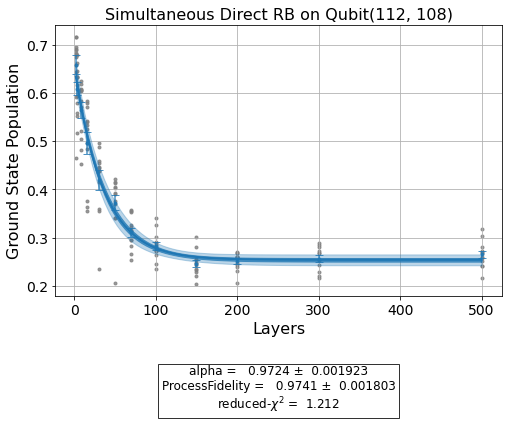

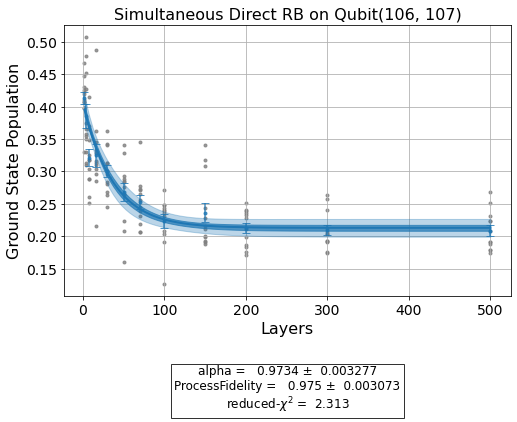

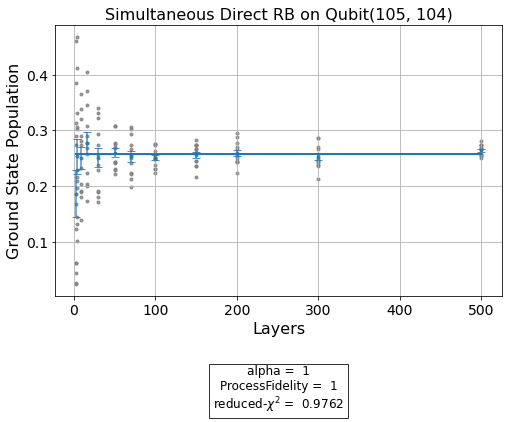

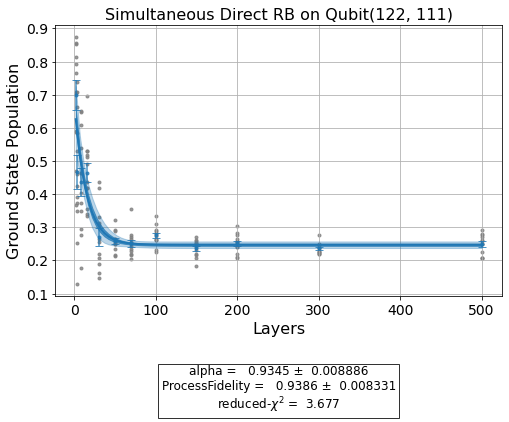

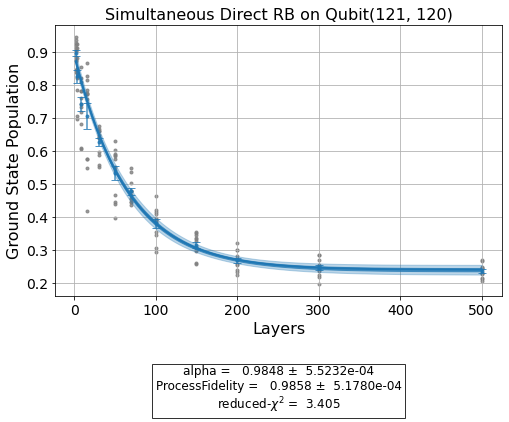

In [20]:
# Plot 1Q/2Q simultaneous direct RB curves
for i in range(0, 5):
    display(exp_data.figure(i))

### Filter qubit pairs with bad process fidelity 

In [21]:
pfdf = df[(df.name == "ProcessFidelity")]
pfdf[pfdf.value < 0.8]

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
4a949ae1,ProcessFidelity,LayerFidelity,"[Q7, Q6]",0.795+/-0.034,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(7, 6)",large_spam,0.203485,0.780861,0.225911,6.248698


### Invesitigate analysis results labeled "bad" quality

In [22]:
# find bad quality analysis results
pfdf[pfdf.quality=="bad"]

,name,experiment,components,value,quality,backend,run_time,qubits,reason,a,alpha,b,chisq
315b252c,ProcessFidelity,LayerFidelity,"[Q112, Q108]",0.9741+/-0.0018,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(112, 108)",large_spam,0.403517,0.972388,0.253707,1.211738
8ba264a8,ProcessFidelity,LayerFidelity,"[Q106, Q107]",0.9750+/-0.0031,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(106, 107)",large_spam,0.192179,0.973366,0.212858,2.313055
fd70efcf,ProcessFidelity,LayerFidelity,"[Q105, Q104]",0.9999999999999999+/-nan,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(105, 104)",large_spam,0.003853,1.0,0.25289,0.97619
329c0c1a,ProcessFidelity,LayerFidelity,"[Q122, Q111]",0.939+/-0.008,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(122, 111)",large_spam,0.433793,0.934506,0.24728,3.67749
b1455dcc,ProcessFidelity,LayerFidelity,"[Q121, Q120]",0.9858+/-0.0005,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(121, 120)",large_chisq,0.652881,0.984827,0.239197,3.405308
ca0ff259,ProcessFidelity,LayerFidelity,"[Q119, Q118]",0.9922+/-0.0004,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(119, 118)",large_chisq,0.570897,0.991682,0.25806,3.158789
156ce79e,ProcessFidelity,LayerFidelity,"[Q82, Q81]",0.9786+/-0.0008,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(82, 81)",large_chisq,0.612284,0.977174,0.256304,4.146358
df2acdc7,ProcessFidelity,LayerFidelity,"[Q80, Q79]",0.9818+/-0.0006,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(80, 79)",large_chisq,0.652751,0.980545,0.253304,3.196182
e40cc5a4,ProcessFidelity,LayerFidelity,"[Q98, Q91]",0.9756+/-0.0011,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(98, 91)",large_chisq,0.580621,0.974021,0.222527,3.307072
91fa4b5e,ProcessFidelity,LayerFidelity,"[Q76, Q77]",0.906+/-0.014,bad,ibm_kyoto,2024-03-21 16:29:46.643000+09:00,"(76, 77)",large_spam,0.250542,0.899955,0.194955,2.241609


In [23]:
RUN_TIME = df[(df.name == "LF")].run_time.values[0]
RUN_TIME

datetime.datetime(2024, 3, 21, 16, 29, 46, 643000, tzinfo=tzlocal())

## Plot Layer Fidelity (EPLG) by chain length

In [24]:
# fill Process Fidelity values with zeros
pfdf = pfdf.fillna({"value": 0})

In [25]:
# Compute LF by chain length assuming the first layer is full with 2q-gates
lf_sets, lf_qubits = two_disjoint_layers, best_qubit_chain
full_layer = [None] * (len(lf_sets[0]) + len(lf_sets[1]))
full_layer[::2] = lf_sets[0]
full_layer[1::2] = lf_sets[1]
full_layer = [(lf_qubits[0],)] + full_layer + [(lf_qubits[-1],)]
len(full_layer)

101

In [26]:
assert(len(full_layer)== len(lf_qubits) + 1)

In [27]:
pfs = [pfdf.loc[pfdf[pfdf.qubits==qubits].index[0], 'value'] for qubits in full_layer]
pfs = list(map(lambda x: x.n if x != 0 else 0, pfs))
pfs[0] = pfs[0]**2
pfs[-1] = pfs[-1]**2
np.array(pfs)

array([0.92055217, 0.9741141 , 0.96208789, 0.97503078, 0.99965795,
       1.        , 0.97987882, 0.93859898, 0.99203894, 0.98577528,
       0.99035144, 0.99220233, 0.98818172, 0.98517995, 0.96736989,
       0.9790599 , 0.97357661, 0.97056358, 0.98155472, 0.97860038,
       0.9742577 , 0.98176111, 0.97835567, 0.97564462, 0.9652965 ,
       0.9890947 , 0.98336868, 0.99009675, 0.97734924, 0.93316685,
       0.95964551, 0.90620797, 0.97686608, 0.97599839, 0.97652024,
       0.9850133 , 0.98775448, 0.98334683, 0.98172138, 0.98223841,
       0.98999861, 0.99096077, 0.98995754, 0.99090252, 0.99226826,
       0.99107934, 0.98650061, 0.97199183, 0.98736921, 0.97831851,
       0.98856905, 0.98560185, 0.98954903, 0.98241734, 0.97179765,
       0.97997059, 0.96498726, 0.98893729, 0.98683034, 0.95981566,
       0.98999975, 0.98376994, 0.9887138 , 0.98631117, 0.9739017 ,
       0.96428246, 0.83541798, 0.7945571 , 0.99311771, 0.98481061,
       0.98572814, 0.97602161, 0.9794883 , 0.98209418, 0.97552

In [28]:
len(pfs)

101

In [29]:
# Approximate 1Q RB fidelities at both ends by the square root of 2Q RB fidelity at both ends.
# For example, if we have [(0, 1), (1, 2), (2, 3), (3, 4)] 2Q RB fidelities and if we want to compute a layer fidelity for [1, 2, 3],
# we approximate the 1Q filedities for (1,) and (3,) by the square root of 2Q fidelities of (0, 1) and (3, 4).
chain_lens = list(range(4, len(pfs), 2))
chain_fids = []
for length in chain_lens:
    w = length + 1  # window size
    fid_w = max(np.sqrt(pfs[s]) * np.prod(pfs[s+1:s+w-1]) * np.sqrt(pfs[s+w-1]) for s in range(len(pfs)-w+1))
    chain_fids.append(fid_w)

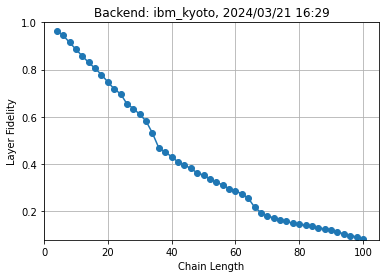

In [30]:
# Plot LF by chain length
plt.title(f"Backend: {backend.name}, {RUN_TIME.strftime('%Y/%m/%d %H:%M')}")
plt.plot(
    chain_lens,
    chain_fids,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1]*1.05)
plt.ylim(0.95*min(chain_fids), 1)
plt.ylabel("Layer Fidelity")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

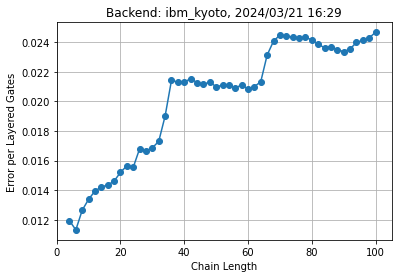

In [31]:
# Plot EPLG by chain length
num_2q_gates = [length -1 for length in chain_lens]
chain_eplgs = [1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)]
plt.title(f"Backend: {backend.name}, {RUN_TIME.strftime('%Y/%m/%d %H:%M')}")
plt.plot(
    chain_lens,
    chain_eplgs,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1]*1.05)
plt.ylabel("Error per Layered Gates")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

### Optional: Load Data from Results DB and rerun analysis

In [ ]:
# %%time
# # load results from DB with experiment_id
# from qiskit_experiments.framework import ExperimentData
# experiment_id = "368f151b-63e9-49db-a36e-66a365948644"  # REPLACE WITH YOUR OWN EXPERIMENT ID
# exp_data = ExperimentData.load(experiment_id, provider=provider)

In [ ]:
# %%time
# # rerun analysis
# new_exp = LayerFidelity(
#     physical_qubits=exp_data.metadata["physical_qubits"],
#     two_qubit_layers=[[tuple(qpair) for qpair in layer] for layer in exp_data.metadata["two_qubit_layers"]],
#     lengths=[2, 4, 8, 16, 30, 50, 70, 100, 150, 200, 300, 500],
#     backend=backend,
#     num_samples=12,
#     seed=42,
# )
# new_exp.analysis.run(exp_data, replace_results=True)
# exp_data.block_for_results()